### 練習

### ファイルの読込

In [1]:
### 13-1

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import train_test_split

# 追加
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import numpy as np #本書ではあまり紹介していないnumpyライブラリ

%matplotlib inline

df=pd.read_csv("../datafiles/Bank.csv")


### データの前処理１（標準化以外）

#### ダミー変数化

In [3]:
#調査
# print(df)

#文字列項目の検出
is_str = list()
for c in df.columns:
    # type(df[c].head[10])
    for v in df[c].head(10):
      if type(v) != int and type(v) != float:
          is_str.append(c)
          break
str_col_name=is_str
str_df = df[str_col_name]

#ダミー変数化
str_df2=pd.get_dummies(str_df,drop_first=True)

#数値列との結合
num_df = df.drop(str_col_name,axis=1)#数値列を抜き出す
df2 = pd.concat([num_df,str_df2,str_df],axis=1)#結合(今後の集計の利便性も考慮してstr_dfも結合しておく)


### データを訓練＆検証とテストの２つに分割

In [4]:
#訓練&検証データとテストデータに分割
train_val,test = train_test_split(df2,test_size=0.1,random_state=9)
train_val.head()

,id,age,amount,day,duration,campaign,previous,y,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,job,marital,education,default,housing,loan,contact,month
13378,13379,46,0.0,10,378.293875,1,0,1,False,False,...,False,False,unemployed,married,tertiary,no,yes,no,cellular,jul
3800,3801,41,-333.0,30,300.845752,3,2,0,True,False,...,False,False,blue-collar,divorced,secondary,no,yes,no,cellular,jan
10398,10399,30,5389.0,6,159.053623,3,0,1,False,False,...,False,False,management,single,tertiary,no,no,no,cellular,aug
23401,23402,39,255.0,5,334.802583,1,0,0,False,False,...,False,False,management,single,tertiary,no,yes,no,sending _document,may
26223,26224,47,33.0,5,NaN,1,0,1,False,False,...,False,False,services,single,secondary,no,yes,no,cellular,may


### 欠損値の補正

### 13-2

<Axes: >

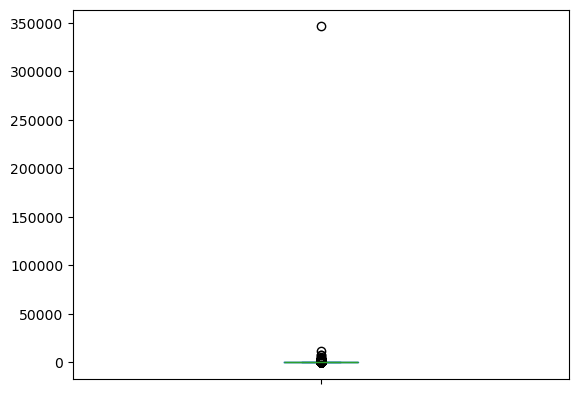

In [5]:
from sklearn.covariance import MinCovDet

#文字の入った列や欠損値のある行をdrop
num_df=train_val.drop(str_col_name,axis=1) #文字の列を取っ払う
num_df=num_df.drop('id',axis=1) #id列を取っ払う
num_df2=num_df.dropna() #欠損列を取っ払う

###欠損値の補正には外れ値は邪魔なので取り除く

#マハラノビス距離を算出し外れ値を検出する
mcd2 =MinCovDet(random_state=0,support_fraction=0.7)
mcd2.fit(num_df2)
dis =mcd2.mahalanobis(num_df2)
dis=pd.Series(dis)
dis.plot(kind="box")


### 13-3

In [6]:
#外れ値のあるインデックスを確認してその行・列を指定してdrop
no=dis[dis>300000].index
# print(no)
no=num_df2.iloc[no[0]:(no[0]+1),:].index
train_val2 = train_val.drop(no)

### 欠損行を削除
# print(train_val2.tail(3))
not_nan_df = train_val2.dropna() #外れ値が無いデータから欠損値をdrop
# print(not_nan_df.tail(3))


In [7]:
#データの関連性の調査
#試しにjob
# print(not_nan_df.columns)
name='job'
cnt =not_nan_df.groupby(name)['y'].value_counts()
df_ = pd.DataFrame(cnt)
print("sum:",df_.sum())
print("----")
print(df_.index[0],df_.iloc[1]/(df_.iloc[0]+df_.iloc[1]))
print("----")
df_

# temp_x = not_nan_df.drop(str_col_name,axis=1) #教師データから文字の列をdrop


sum: count    18083
dtype: int64
----
('admin.', 0) count    0.33018
dtype: float64
----


count
job           y       
admin.        0   1416
              1    698
blue-collar   0   2799
              1   1476
entrepreneur  0    382
              1    258
housemaid     0    319
              1    174
management    0   2211
              1   1336
retired       0    666
              1    367
self-employed 0    359
              1    222
services      0   1155
              1    624
student       0    137
              1     81
technician    0   1836
              1   1017
unemployed    0    311
              1    139
unknown       0     57
              1     43

In [8]:
#データの関連性の調査
#試しにduration
# print(not_nan_df.columns)
name='duration'
cnt =not_nan_df.groupby(name)['y'].value_counts()
df_ = pd.DataFrame(cnt)
print("sum:",df_.sum())
print("----")
print(df_.index[0],df_.iloc[1]/(df_.iloc[0]+df_.iloc[1]))
print("----")
df_

# temp_x = not_nan_df.drop(str_col_name,axis=1) #教師データから文字の列をdrop


sum: count    18083
dtype: int64
----
(19.038719443648237, 0) count    0.5
dtype: float64
----


,,count
duration,y,
19.038719,0,1
34.009388,0,1
46.910033,0,1
50.514705,0,1
52.774810,0,1
...,...,...
608.230566,1,1
610.989820,1,1
612.402981,1,1


In [9]:
#他のデータとの関連性
for name in not_nan_df.columns:
    print(not_nan_df.groupby(name)['y'].mean().tail(3))
    print("next=========")


print(not_nan_df.groupby("duration")['y'].mean().tail(3))

id
27126    0.0
27127    1.0
27128    0.0
Name: y, dtype: float64
next=========
age
92    1.0
93    1.0
94    0.0
Name: y, dtype: float64
next=========
amount
64343.0     0.0
66721.0     0.0
102127.0    0.0
Name: y, dtype: float64
next=========
day
29    0.361823
30    0.435484
31    0.422131
Name: y, dtype: float64
next=========
duration
612.402981    1.0
615.048733    1.0
632.388923    1.0
Name: y, dtype: float64
next=========
campaign
55    0.0
58    0.0
63    0.0
Name: y, dtype: float64
next=========
previous
40    1.0
41    1.0
51    1.0
Name: y, dtype: float64
next=========
y
0    0.0
1    1.0
Name: y, dtype: float64
next=========
job_blue-collar
False    0.359140
True     0.345263
Name: y, dtype: float64
next=========
job_entrepreneur
False    0.354125
True     0.403125
Name: y, dtype: float64
next=========
job_housemaid
False    0.355941
True     0.352941
Name: y, dtype: float64
next=========
job_management
False    0.350784
True     0.376656
Name: y, dtype: float64
next=======

In [10]:
#正解データの抽出
temp_t =not_nan_df[['duration']] #正解データ

#教師データの抽出
temp_x = not_nan_df.drop(str_col_name,axis=1)

#durationとyに関係があるという仮定が成り立つならば、適切な推定をするためには,
temp_x = temp_x.drop(['y','duration','id'],axis=1)
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Lasso,Ridge

#推定の検証
a,b,c,d= train_test_split(temp_x,temp_t,random_state=0,test_size=0.2)
maxvalue=0
v=0
#今回はLasso回帰を利用するので、特徴量選択はしない
for i in range(1,42):
    val = i/20
    model_liner = Lasso(random_state=0,alpha=val)
    #今回は予測させたいだけなので、標準化はしない
    model_liner.fit(a,c)
    if maxvalue < model_liner.score(b,d):
        v=val #決定係数が最大になるalpha値
        maxvalue = model_liner.score(b,d) #決定係数の最大値
print(v,maxvalue)
model_liner = Lasso(random_state=0,alpha=v)
#今回は予測させたいだけなので、標準化はしない
model_liner.fit(a,c)
#pd.Series(model_liner)


0.15 0.7304944118304566


Lasso(alpha=0.15, random_state=0)

In [11]:
#実際の欠損値の補正対象は外れ値込みのデータ（train_val）
train_val3 = train_val.copy()
is_null=train_val3['duration'].isnull()
temp_x = train_val3.drop(str_col_name,axis=1)
temp_x = temp_x.drop(['y','duration','id'],axis=1)
temp_x = temp_x[is_null]
#non_x=train_val2.loc[is_null,['housing_yes','loan_yes','age','marital_single','job_student']]
pred_d = model_liner.predict(temp_x)
train_val3.loc[is_null,'duration']=pred_d

### アンダーサンプリング

In [12]:
#12章付録で紹介したアンダーサンプリングを行いy=0or1のデータ数を揃える
def under_sampling(train_val):
    y_0=train_val[train_val['y']==0]
    y_1=train_val[train_val['y']==1]
    num_1 = len(y_1)
    #Y=1と同じ件数だけサンプリング
    y_0_2 =y_0.sample(n=num_1,random_state=0)
    ret_train_val = pd.concat([y_1,y_0_2])
    return ret_train_val
    # train_val2 = pd.concat([y_1,y_0_2])
    # return train_val2


### モデルの作成

In [13]:
#学習をさせよう。ただし、13章で学習した知識を使いたい。これまでは正解率を考えてきたが、今回のケースだと適合率
#再現率のどちらを見るべきだろうか？

# y=1の適合率が高い⇒無駄なアポイントメントを減らす事が出来る。
# y=1の再現率が高い⇒潜在顧客を見逃さない

#スッキリ銀行は、効率よくキャンペーンを回したいと考えているので、y=1適合率に着目する


In [14]:
#まず、さくっと学習できるようなlearn関数を定義する。ただし、正解率では無くて適合率をみる
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
def learn(x,t,i):
    x_train,x_val,y_train,y_val = train_test_split(x,t,test_size=0.2,random_state=13)

    datas=[x_train,x_val,y_train,y_val]
    base = DecisionTreeClassifier(max_depth=i,random_state=0,class_weight="balanced")
    #model = AdaBoostClassifier(n_estimators=150,base_estimator=base,random_state=0)
    
    #　追加
    
    base.fit(x_train,y_train)
    train_pred = base.predict(x_train)
    test_pred = base.predict(x_val)
    result = classification_report(y_pred=test_pred,y_true=y_val,output_dict=True)
    # result = classification_report(y_pred=test_pred,y_true=y_val,output_dict=True,n_jobs=-1)
    return result,base,datas

t =train_val3['y']
x = train_val3.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)
res,model,datas = learn(x,t,i=8)
res_df=pd.DataFrame(res)
res_df
#res_df.iloc[0,1]


,0,1,accuracy,macro avg,weighted avg
precision,0.909322,0.587959,0.769404,0.748640,0.810603
recall,0.741058,0.833333,0.769404,0.787196,0.769404
f1-score,0.816612,0.689465,0.769404,0.753039,0.777554
support,3383.000000,1500.000000,0.769404,4883.000000,4883.000000


In [15]:
# 0	1	accuracy	macro avg	weighted avg
# precision	0.909322	0.587959	0.769404	0.748640	0.810603
# recall	0.741058	0.833333	0.769404	0.787196	0.769404
# f1-score	0.816612	0.689465	0.769404	0.753039	0.777554
# support	3383.000000	1500.000000	0.769404	4883.000000	4883.000000

In [16]:
#適合率が低い。
# 12章で学習したランダムフォレストとアダブーストだとどうなるか？
def learn2(x,t,i,de=5,forest=True):
    x_train,x_val,y_train,y_val = train_test_split(x,t,test_size=0.2,random_state=13)

    datas=[x_train,x_val,y_train,y_val]
    model=None
    if forest:
        model = RandomForestClassifier(n_estimators=i,random_state=0,max_depth=de,class_weight="balanced")
    #datas=[x_train,x_val,y_train,y_val]
    else:
        base = DecisionTreeClassifier(max_depth=de,random_state=0,class_weight="balanced")
        model = AdaBoostClassifier(n_estimators=i,estimator=base,random_state=0)
    #model = AdaBoostClassifier(n_estimators=150,base_estimator=base,random_state=0)
    model.fit(x_train,y_train)
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_val)
    result = classification_report(y_pred=test_pred,y_true=y_val,output_dict=True)
    # result = classification_report(y_pred=test_pred,y_true=y_val,output_dict=True,n_jobs=-1)
    return result,model,datas
t =train_val3['y']
x = train_val3.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)


In [17]:
#ランダムフォレストでの検証
print("=================random_forest=========================")
max_pre=0
for i in [50,100,150,200]:#esti
    for j in range(5,11):#depth
        res,model,datas = learn2(x,t,i=i,de=j,forest=True)
        res2=pd.DataFrame(res)
        pre = res2.iloc[0,1]
        if max_pre < pre:
            max_pre=pre
            print(max_pre,i,j)
        print(i,j,pre,"finish next_i")
#アダブーストでの検証
print("=================adaboost=========================")
max_pre=0
for i in [50,100,150,200]:#esti
    for j in range(5,11):#depth
        res,model,datas = learn2(x,t,i=i,de=j,forest=False)
        res2=pd.DataFrame(res)
        pre = res2.iloc[0,1]
        if max_pre < pre:
            max_pre=pre
            print(max_pre,i,j)
        print(i,j,pre,"finish next_i")


=================random_forest=========================
0.5562622309197651 50 5
50 5 0.5562622309197651 finish next_i
0.5626511852926948 50 6
50 6 0.5626511852926948 finish next_i
0.5655339805825242 50 7
50 7 0.5655339805825242 finish next_i
0.5736661771904062 50 8
50 8 0.5736661771904062 finish next_i
0.5800677310111272 50 9
50 9 0.5800677310111272 finish next_i
0.5950704225352113 50 10
50 10 0.5950704225352113 finish next_i
100 5 0.5662650602409639 finish next_i
100 6 0.5725765946760422 finish next_i
100 7 0.5699456253089471 finish next_i
100 8 0.5768274490303331 finish next_i
100 9 0.5860029571217349 finish next_i
100 10 0.5932629462041227 finish next_i
150 5 0.5666003976143141 finish next_i
150 6 0.57135703555333 finish next_i
150 7 0.5707920792079207 finish next_i
150 8 0.5805805805805806 finish next_i
150 9 0.5837864557587741 finish next_i
150 10 0.5903371917463512 finish next_i
200 5 0.5655860349127182 finish next_i
200 6 0.5723651033787192 finish next_i
200 7 0.5705159705159705

### 13-9

In [18]:
#非常に時間がかかるので途中で終了。
#random_forestよりadaboostの方がvalデータの精度が良く、その中でもestimator=100,max_depth=8が最も高い

#estimatorの値を100と固定して、max_depthについての考察を深める。k-分割交差検証
#で最適なmax_depthを考察するｂ
def learn_k_valid(x,t,i,dep):
    base = DecisionTreeClassifier(max_depth=dep,random_state=0,class_weight="balanced")
    # model = AdaBoostClassifier(n_estimators=150,estimator=base,random_state=0)
    model = AdaBoostClassifier(n_estimators=i,estimator=base,random_state=0)
    kv = StratifiedKFold(n_splits=3,shuffle=True,random_state=0)
    result = cross_validate(model,x,t,cv=kv,scoring='precision',return_train_score=True)
    # result = cross_validate(model,x,t,cv=kv,scoring='precision',return_train_score=True,n_jobs=-1)
    
    #base.fit(x_train,y_train)
    #train_pred = base.predict(x_train)
    #test_pred = base.predict(x_val)
    #result = classification_report(y_pred=test_pred,y_true=y_val,output_dict=True)
    return result


### 13-10

In [19]:
t =train_val3['y']
x = train_val3.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)
for j in range(2,10):
    res = learn_k_valid(x,t,i=100,dep=j)
    res2=res["train_score"]
    print(j,sum(res2)/len(res2),end="  ")#平均値    
    res3=res["test_score"]
    
    print(j,sum(res3)/len(res3))#平均値
    print(" j end next")

2 0.6851614806712366  2 0.659718307531895
 j end next
3 0.7110781452772317  3 0.6491364827217284
 j end next
4 0.7720167629129425  4 0.6365612938189156
 j end next
5 0.8698396728632231  5 0.6312565129037072
 j end next
6 0.9792843419275447  6 0.6158629351733168
 j end next
7 1.0  7 0.6273659301928091
 j end next
8 1.0  8 0.6650213961538926
 j end next
9 1.0  9 0.6786747144624301
 j end next


In [20]:
#検証データの適合率が最も良いのは深さ9だが、明らかに過学習している。
# アンダーサンプリングで不均衡データの影響が変わるか確認してみる


### 13-11

In [21]:
train_val4 = under_sampling(train_val3)
t =train_val4['y']
x = train_val4.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)
for j in range(2,10):
    res = learn_k_valid(x,t,i=100,dep=j)
    res2=res["train_score"]
    print(j,sum(res2)/len(res2),end="  ")#平均値    
    res3=res["test_score"]
    
    print(j,sum(res3)/len(res3))#平均値
    print(" j end next")

2 0.8264622332806147  2 0.7966588761440541
 j end next
3 0.8589197345440344  3 0.7818225990470737
 j end next
4 0.9109614739925763  4 0.7624974697640458
 j end next
5 0.9785949665103897  5 0.7425260761678869
 j end next
6 1.0  6 0.7322160032739804
 j end next
7 1.0  7 0.7436717170061913
 j end next
8 1.0  8 0.7553528087980252
 j end next
9 1.0  9 0.7640159284747785
 j end next


In [22]:
#深さ2~３当たりが最もよさそうである。
#テストデータで検証するために再学習

In [23]:
train_val4=under_sampling(train_val3)
t =train_val4['y']
x = train_val4.drop(str_col_name,axis=1)
x =x.drop(['id','y','day'],axis=1)
base_model = RandomForestClassifier(max_depth=3,random_state=0,class_weight="balanced")
model = AdaBoostClassifier(random_state=0,n_estimators=100,estimator=base_model)
model.fit(x,t)

AdaBoostClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                    max_depth=3,
                                                    random_state=0),
                   n_estimators=100, random_state=0)

In [24]:
#テストデータ
test2 = test.copy()    
isnull=test2['duration'].isnull()
print(isnull.shape)
if isnull.sum()>0:
    temp_x = test2.drop(str_col_name,axis=1)
    temp_x = temp_x.drop(['y','duration','id'],axis=1)
    temp_x = temp_x[isnull]
    pred_d = model_liner.predict(temp_x)
    test2.loc[isnull,'duration']=pred_d    
x_test = test2.drop(str_col_name,axis=1)
x_test =x_test.drop(['id','y','day'],axis=1)
y_test = test['y']

(2713,)


In [25]:
pre = model.predict(x_test)
result= classification_report(y_pred=pre,y_true=y_test,output_dict=True)
# result= classification_report(y_pred=pre,y_true=y_test,output_dict=True,n_jobs=-1)
pd.DataFrame(result)

,0,1,accuracy,macro avg,weighted avg
precision,0.894219,0.641214,0.792849,0.767717,0.813179
recall,0.788503,0.802071,0.792849,0.795287,0.792849
f1-score,0.838040,0.712679,0.792849,0.775360,0.797886
support,1844.000000,869.000000,0.792849,2713.000000,2713.000000


In [ ]:
#y=1の適合率は0.64

In [26]:

#本書で紹介していないnumpyのテクニックを使っているが
#同様の事はpandasでもできる
#参考　予測確率の閾値を変更する事により予測結果を変えて調整する
#確率でいったん予測させる
y_p = model.predict_proba(x)
y_p
a=y_p[:,1]#y=1の確率を抜き出す
def conf(a,th=0.5):
    import numpy as np
    y_pre=np.where(a<th,0,1)#閾値以下なら0,以上なら1
    from sklearn.metrics import confusion_matrix
    #混同行列をscikit-learnの関数で作成
    mat= confusion_matrix(y_pred=y_pre,y_true=t)
    pre = mat[1,1]/(mat[1,1]+mat[0,1])
    re = mat[1,1]/(mat[1,1]+mat[1,0])
    f1 = 2*(pre*re)/(pre+re)
    return pre,f1,mat#適合率、ｆ１スコア、混同行列
conf(a,0.5)#閾値0.5

(0.8333544544417691,
 0.8374403056351482,
 array([[6499, 1315],
        [1238, 6576]], dtype=int64))

In [27]:
#presitionを上げるためには閾値をもう少しあげればよい
#ただし、閾値を上げすぎると適合率が低下してしまうのでf1スコアも意識する
for i in range(1,30):
    val = 0.50+(i/1000)
    print(i)
    b=conf(a,val)#閾値0.5
    print(val,b[0],b[1])

1
0.501 0.8664850136239782 0.8172043010752689
2
0.502 0.8967491999326259 0.7743436840957023
3
0.503 0.9248623131392604 0.7291052876414948
4
0.504 0.9497379704621248 0.663836163836164
5
0.505 0.9674502712477396 0.5767157743442329
6
0.506 0.9809930178432894 0.48672055427251737
7
0.507 0.9881382155750387 0.39290474725725416
8
0.508 0.9909027291812457 0.30639402791301523
9
0.509 0.9950592885375494 0.22818944029005214
10
0.51 0.998641304347826 0.1719298245614035
11
0.511 1.0 0.12523992322456812
12
0.512 1.0 0.08597672994488673
13
0.513 1.0 0.05790978004225177
14
0.514 1.0 0.03963873557451079
15
0.515 1.0 0.024023264635225694
16
0.516 1.0 0.014231257941550191
17
0.517 1.0 0.00891833354567461
18
0.518 1.0 0.00663265306122449
19
0.519 1.0 0.004341718809858256
20
0.52 1.0 0.0025562372188139056
21
0.521 1.0 0.0010232796111537478
22
0.522 1.0 0.0007675578866572853
23
0.523 1.0 0.0007675578866572853
24
0.524 1.0 0.0007675578866572853
25
0.525 nan nan
26
0.526 nan nan
27
0.527 nan nan
28
0.528 nan 

C:\Users\user\AppData\Local\Temp\ipykernel_12252\12843953.py:14: RuntimeWarning: invalid value encountered in scalar divide
  pre = mat[1,1]/(mat[1,1]+mat[0,1])
C:\Users\user\AppData\Local\Temp\ipykernel_12252\12843953.py:14: RuntimeWarning: invalid value encountered in scalar divide
  pre = mat[1,1]/(mat[1,1]+mat[0,1])
C:\Users\user\AppData\Local\Temp\ipykernel_12252\12843953.py:14: RuntimeWarning: invalid value encountered in scalar divide
  pre = mat[1,1]/(mat[1,1]+mat[0,1])
C:\Users\user\AppData\Local\Temp\ipykernel_12252\12843953.py:14: RuntimeWarning: invalid value encountered in scalar divide
  pre = mat[1,1]/(mat[1,1]+mat[0,1])
C:\Users\user\AppData\Local\Temp\ipykernel_12252\12843953.py:14: RuntimeWarning: invalid value encountered in scalar divide
  pre = mat[1,1]/(mat[1,1]+mat[0,1])


In [28]:
#閾値を0.503にすると全体的に最もよさそう。
th=0.503
#テストデータ
proba = model.predict_proba(x_test)

In [29]:
a = proba[:,1]
pre=np.where(a<th,0,1)
result= classification_report(y_pred=pre,y_true=y_test,output_dict=True)
# result= classification_report(y_pred=pre,y_true=y_test,output_dict=True,n_jobs=-1)
pd.DataFrame(result)

,0,1,accuracy,macro avg,weighted avg
precision,0.813256,0.747678,0.797641,0.780467,0.792251
recall,0.911605,0.555811,0.797641,0.733708,0.797641
f1-score,0.859627,0.637624,0.797641,0.748625,0.788517
support,1844.000000,869.000000,0.797641,2713.000000,2713.000000
